# Laboration maskininlärning AI21


## 2. Disease prediction
### 2.0 - EDA uppvärmning


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import PercentFormatter

In [2]:
df_cardio = pd.read_csv("Data/cardio_train.csv", sep=";").set_index("id")
df_cardio["age_years"] = (df_cardio["age"] / 365.25)

df_cardio.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years
id,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50.357290
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55.381246
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51.627652
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48.249144
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47.841205


In [3]:
df_cardio.query("weight >=200" )#"height < 120 and height >= 000")


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years
id,,,,,,,,,,,,,
618,16765,1,186,200.0,130,70,1,1,0,0,0,0,45.900068
71945,15117,2,180,200.0,150,90,1,1,0,0,1,1,41.388090



#### a) Hur många är positiva för hjärt-kärlsjukdom och hur många är negativa?


<AxesSubplot:xlabel='cardio', ylabel='count'>

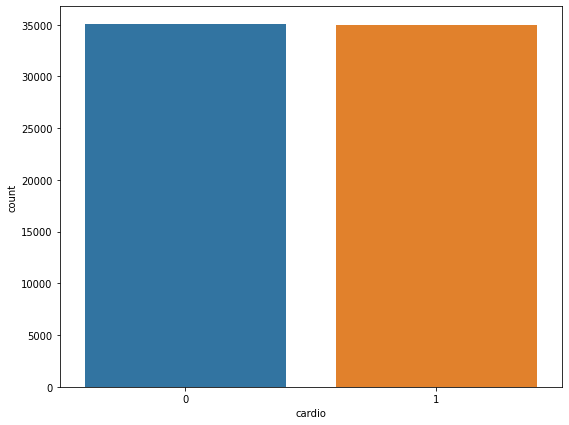

In [4]:
plt.figure(figsize = [9, 7])
sns.countplot(x=df_cardio["cardio"])
# Lika många i båda grupperna


#### b) Hur stor andel har normala, över normala och långt över normala kolesterolvärden? Rita ett tårtdiagram.


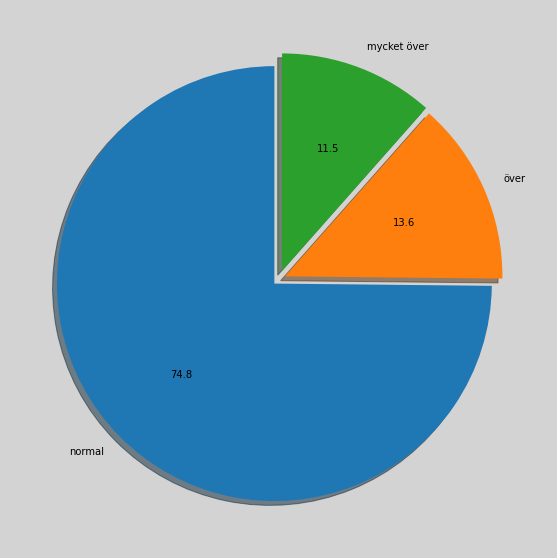

In [5]:

fig  = plt.figure(figsize = [10, 10])
plt.pie(df_cardio["cholesterol"].value_counts(), labels = ("normal", "över", "mycket över"), autopct="%.1f", startangle=90, explode=(0.03, 0.03, 0.04), shadow=True, )

fig.set_facecolor('lightgrey')


#### c) Hur ser åldersfördelningen ut? Rita ett histogram.


In [6]:

def histogram(df, feature, binwidth=1 ):
    bin_range = (np.floor(df[feature].min()), np.floor(df_cardio[feature].max())) 
    bin_range = (bin_range[0] - bin_range[0] % binwidth, bin_range[1] - bin_range[1] % binwidth + binwidth)
    
    print("bin_range:", bin_range )
    plt.figure(figsize = [10, 10])
    sns.histplot(df_cardio, x=feature, binrange=bin_range,  binwidth=binwidth)


bin_range: (29.0, 65.0)


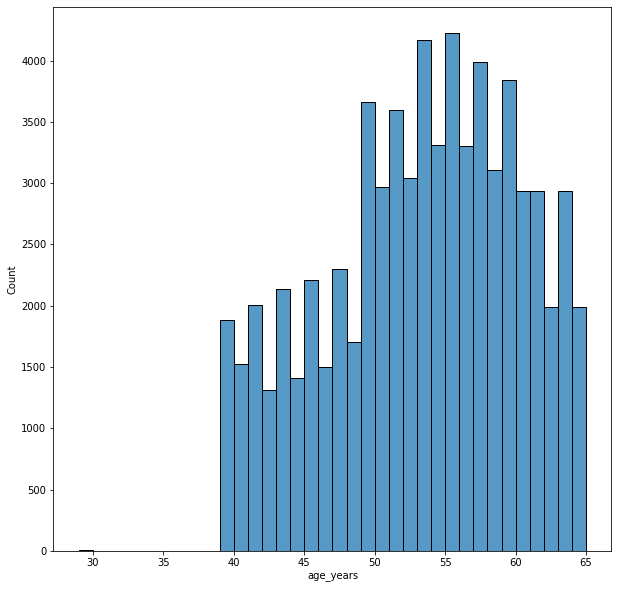

In [7]:
histogram(df_cardio, "age_years")


#### d) Hur stor andel röker?


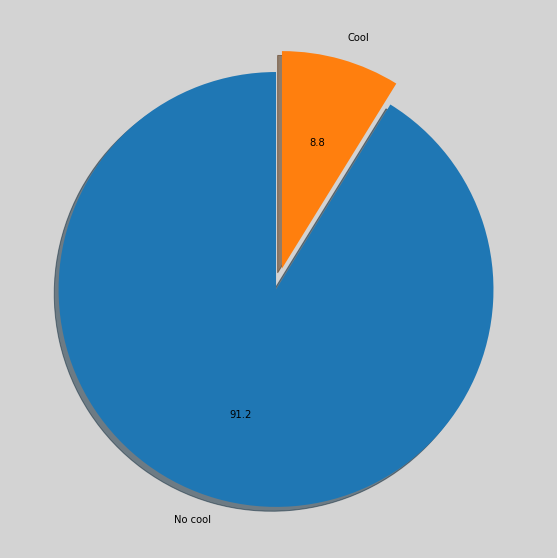

In [8]:

fig  = plt.figure(figsize = [10, 10])
plt.pie(df_cardio["smoke"].value_counts(), labels = ("No cool", "Cool"), autopct="%.1f", startangle=90, explode=(0.05, 0.05), shadow=True, )

fig.set_facecolor('lightgrey')



#### e) Hur ser viktfördelningen ut? Rita lämpligt diagram.


bin_range: (10.0, 205.0)


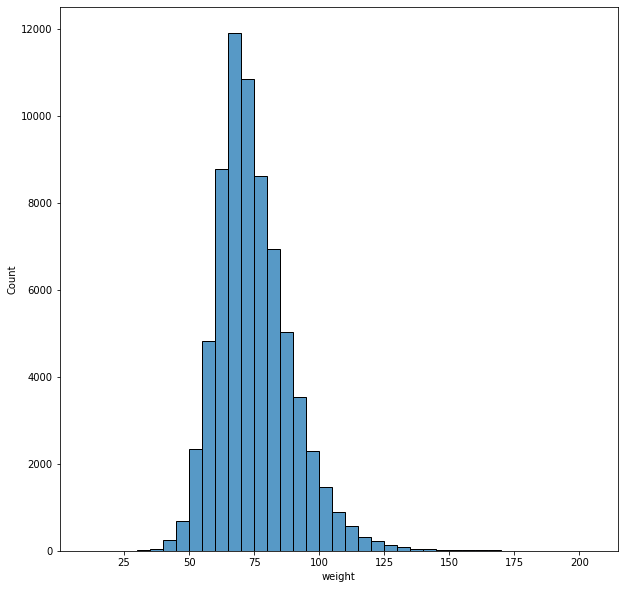

In [9]:

histogram(df_cardio, "weight", 5)


#### f) Hur ser längdfördelningen ut? Rita lämpligt diagram.


bin_range: (55.0, 255.0)


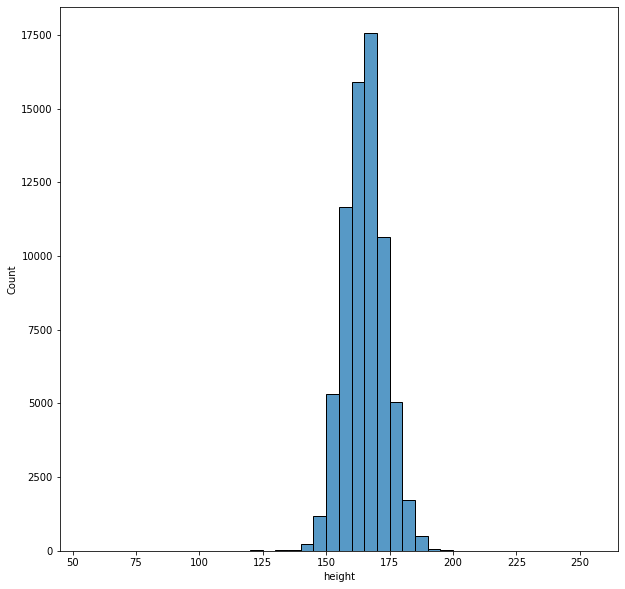

In [10]:
histogram(df_cardio, "height", 5)


#### g) Hur stor andel av kvinnor respektive män har hjärt-kärlsjukdom? Rita lämpligt diagram


In [11]:

df_cardio_plot = df_cardio.copy()
df_cardio_plot["gender"] = "female"
df_cardio_plot["gender"][df_cardio["gender"] == 2] = "male"

df_cardio_plot["gender"]


C:\Users\ErikLarsson-AIU21GBG\AppData\Local\Temp\ipykernel_14240\2080045840.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cardio_plot["gender"][df_cardio["gender"] == 2] = "male"


id
0          male
1        female
2        female
3          male
4        female
          ...  
99993      male
99995    female
99996      male
99998    female
99999    female
Name: gender, Length: 70000, dtype: object

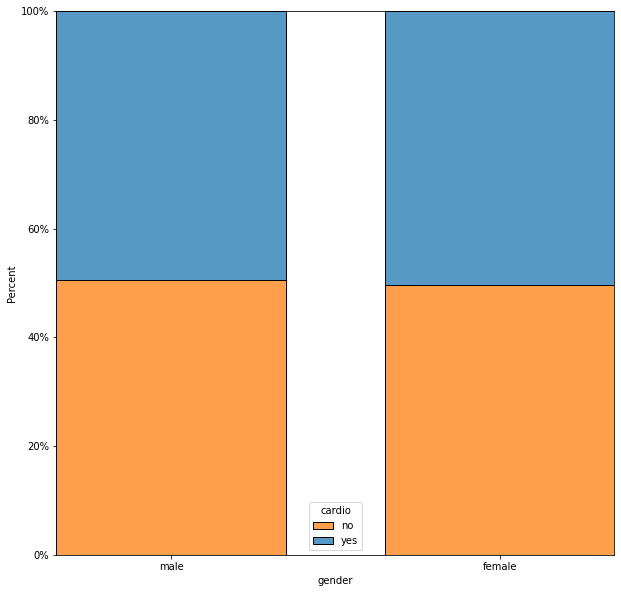

In [12]:
fig  = plt.figure(figsize = [10, 10])

ax = sns.histplot(df_cardio_plot, x="gender", hue= "cardio", stat="percent", multiple="fill", shrink=0.7 , )
ax.xaxis.set
ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.legend(["no", "yes"], title="cardio");


### 2.1.0 - Feature engineering BMI



In [13]:
# BMI rimliga värden
bmi_min = 15
bmi_max = 50


In [14]:
# BMI = massa / längd^2
df_cardio["bmi"] = df_cardio["weight"] / (df_cardio["height"]/100)**2 
df_cardio

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi
id,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50.357290,21.967120
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55.381246,34.927679
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51.627652,23.507805
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48.249144,28.710479
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47.841205,23.011177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99993,19240,2,168,76.0,120,80,1,1,1,0,1,0,52.676249,26.927438
99995,22601,1,158,126.0,140,90,2,2,0,0,1,1,61.878166,50.472681
99996,19066,2,183,105.0,180,90,3,1,0,1,0,1,52.199863,31.353579


In [15]:
df_cardio.query("bmi < @bmi_min")

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi
id,,,,,,,,,,,,,,
7634,16755,1,167,41.0,110,80,1,1,0,0,1,0,45.872690,14.701137
9223,21220,1,250,86.0,140,100,3,1,0,0,1,1,58.097194,13.760000
13518,20958,2,172,40.0,140,90,1,2,0,0,1,1,57.379877,13.520822
14908,22007,1,162,38.0,100,70,1,1,0,0,1,0,60.251882,14.479500
18415,15574,2,174,45.0,130,100,2,2,0,0,0,1,42.639288,14.863258
23181,19621,1,196,56.0,125,80,1,1,0,0,1,0,53.719370,14.577259
23318,21872,1,165,35.0,100,70,1,1,0,0,1,0,59.882272,12.855831
24167,17272,2,170,31.0,150,90,2,2,0,0,1,1,47.288159,10.726644
24244,21860,1,165,40.0,90,60,2,1,0,0,1,1,59.849418,14.692378


In [16]:
df_cardio.query("bmi > @bmi_max")

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi
id,,,,,,,,,,,,,,
309,21800,2,76,55.0,120,80,1,1,0,0,1,0,59.685147,95.221607
474,21078,1,157,142.0,120,80,1,1,0,0,1,1,57.708419,57.608828
552,16718,2,165,169.0,120,80,1,1,0,0,1,0,45.771389,62.075298
618,16765,1,186,200.0,130,70,1,1,0,0,0,0,45.900068,57.810151
712,17381,1,151,117.0,160,90,2,1,0,0,0,1,47.586585,51.313539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98348,22599,1,154,125.0,140,80,3,3,0,0,1,0,61.872690,52.707033
98630,20401,2,120,80.0,140,90,1,2,0,0,1,1,55.854894,55.555556
98709,19077,2,175,155.0,110,100,1,1,0,0,1,1,52.229979,50.612245


In [17]:
df_cardio["bmi_cat"] = pd.cut(df_cardio["bmi"], bins= [0, bmi_min, 25, 30, 35, 40, bmi_max, np.inf], 
        labels=["To low", "Normal range", "Overweight", "Obese (Class I)", "Obese (Class II)", "Obese (Class III)", "To high"])

df_cardio["bmi_cat"] = pd.Categorical(df_cardio["bmi_cat"], ["To low", "Normal range", "Overweight", "Obese (Class I)", "Obese (Class II)", "Obese (Class III)", "To high"])

df_cardio.query("bmi_cat > 'To low' and bmi_cat < 'To high'", inplace=True)
df_cardio

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi,bmi_cat
id,,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50.357290,21.967120,Normal range
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55.381246,34.927679,Obese (Class I)
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51.627652,23.507805,Normal range
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48.249144,28.710479,Overweight
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47.841205,23.011177,Normal range
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99992,21074,1,165,80.0,150,80,1,1,0,0,1,1,57.697467,29.384757,Overweight
99993,19240,2,168,76.0,120,80,1,1,1,0,1,0,52.676249,26.927438,Overweight
99996,19066,2,183,105.0,180,90,3,1,0,1,0,1,52.199863,31.353579,Obese (Class I)


In [18]:
df_cardio.query("height < 130 and height >= 00")

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi,bmi_cat
id,,,,,,,,,,,,,,,
5278,17642,1,120,70.0,120,70,1,1,0,0,1,0,48.301164,48.611111,Obese (Class III)
5306,15400,1,120,30.0,110,70,1,1,0,0,1,0,42.162902,20.833333,Normal range
13691,22482,2,120,68.0,150,1000,2,1,0,0,0,1,61.552361,47.222222,Obese (Class III)
24690,17530,1,98,45.0,12,80,1,1,0,0,1,0,47.994524,46.855477,Obese (Class III)
35681,20988,1,120,69.0,120,80,1,1,0,0,0,0,57.462012,47.916667,Obese (Class III)
44459,19059,2,125,70.0,120,70,1,1,0,0,1,0,52.180698,44.800000,Obese (Class III)
48976,14664,2,128,28.0,120,80,1,1,0,0,1,0,40.147844,17.089844,Normal range
58202,22033,2,120,60.0,130,90,1,1,1,0,1,0,60.323066,41.666667,Obese (Class III)
79014,20376,2,125,49.0,110,70,1,1,0,0,1,0,55.786448,31.360000,Obese (Class I)


### 2.1.1 - Feature engineering blodtryck

In [19]:
# Blodtryck rimliga värden

# Systoliskt blodtryck
ap_hi_min = 40
ap_hi_max = 250

# Diastoliskt blodtryck
ap_lo_min = 20
ap_lo_max = 190


In [20]:
df_cardio.query("ap_lo > @ap_lo_min and ap_lo < @ap_lo_max and " +
                "ap_hi > @ap_hi_min and ap_hi < @ap_hi_max")
df_cardio

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi,bmi_cat
id,,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0,50.357290,21.967120,Normal range
1,20228,1,156,85.0,140,90,3,1,0,0,1,1,55.381246,34.927679,Obese (Class I)
2,18857,1,165,64.0,130,70,3,1,0,0,0,1,51.627652,23.507805,Normal range
3,17623,2,169,82.0,150,100,1,1,0,0,1,1,48.249144,28.710479,Overweight
4,17474,1,156,56.0,100,60,1,1,0,0,0,0,47.841205,23.011177,Normal range
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99992,21074,1,165,80.0,150,80,1,1,0,0,1,1,57.697467,29.384757,Overweight
99993,19240,2,168,76.0,120,80,1,1,1,0,1,0,52.676249,26.927438,Overweight
99996,19066,2,183,105.0,180,90,3,1,0,1,0,1,52.199863,31.353579,Obese (Class I)


In [21]:
def blood_pressure_range(row):
    ap_hi = row["ap_hi"]
    ap_lo = row["ap_lo"]

    if ap_hi < 120 and ap_lo < 80:
        return "Helthy"
    elif ap_hi < 130 and ap_lo < 80:
        return "Elevated"
    elif ap_hi < 140 and ap_lo < 90:
        return "Stage 1 hypertension"
    elif ap_hi < 180 and ap_lo < 120:
        return "Stage 2 hypertension"
    else:
        return "Hypertension crisis"


In [22]:
df_cardio["ap_cat"] = df_cardio.apply(lambda row: blood_pressure_range(row), axis=1)

df_cardio["ap_cat"] = pd.Categorical(df_cardio["ap_cat"], ["Helthy", "Elevated", "Stage 1 hypertension", "Stage 2 hypertension", "Hypertension crisis"])

### 2.2.0 - Visualiseringar andel sjukdomar


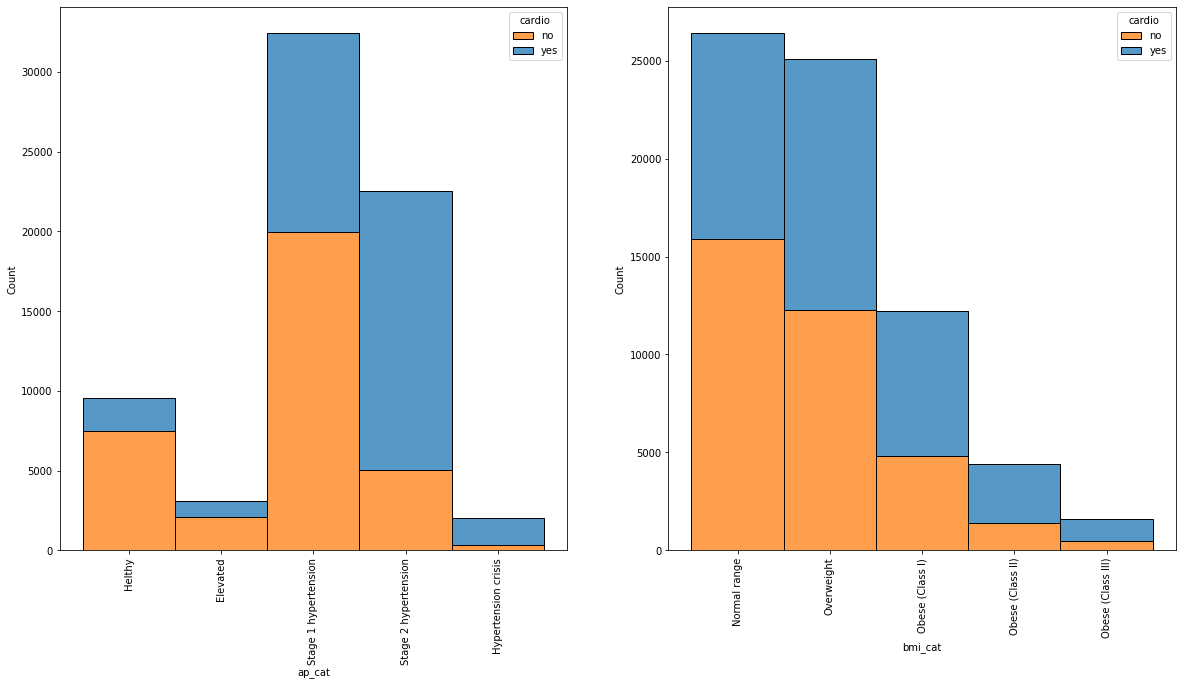

In [23]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.histplot(df_cardio, x="ap_cat", hue="cardio", multiple="stack", hue_order=(1, 0))
plt.xticks(rotation=90)
plt.legend(["no", "yes"], title="cardio")

plt.subplot(1, 2, 2)
sns.histplot(df_cardio, x="bmi_cat", hue="cardio", multiple="stack", hue_order=(1, 0))
plt.xticks(rotation=90)
plt.legend(["no", "yes"], title="cardio");

### 2.2.1 - Visualiseringar korrelation

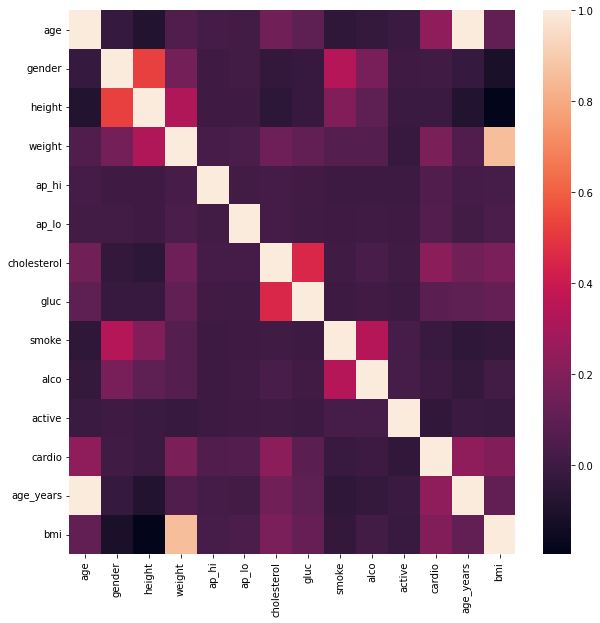

In [24]:
plt.figure(figsize=(10,10))
sns.heatmap(df_cardio.corr(), );

### 2.3 - Skapa två dataset


In [38]:
df_cardio_1 = df_cardio.copy()
df_cardio_1.drop(["ap_hi", "ap_lo", "height", "weight", "bmi"], inplace=True, axis=1)
df_cardio_1 = pd.get_dummies(df_cardio_1, columns=["gender", "ap_cat", "bmi_cat"], drop_first=True)

df_cardio_1

,age,cholesterol,gluc,smoke,alco,active,cardio,age_years,gender_2,ap_cat_Elevated,ap_cat_Stage 1 hypertension,ap_cat_Stage 2 hypertension,ap_cat_Hypertension crisis,bmi_cat_Normal range,bmi_cat_Overweight,bmi_cat_Obese (Class I),bmi_cat_Obese (Class II),bmi_cat_Obese (Class III),bmi_cat_To high
id,,,,,,,,,,,,,,,,,,,
0,18393,1,1,0,0,1,0,50.357290,1,0,1,0,0,1,0,0,0,0,0
1,20228,3,1,0,0,1,1,55.381246,0,0,0,1,0,0,0,1,0,0,0
2,18857,3,1,0,0,0,1,51.627652,0,0,1,0,0,1,0,0,0,0,0
3,17623,1,1,0,0,1,1,48.249144,1,0,0,1,0,0,1,0,0,0,0
4,17474,1,1,0,0,0,0,47.841205,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99992,21074,1,1,0,0,1,1,57.697467,0,0,0,1,0,0,1,0,0,0,0
99993,19240,1,1,1,0,1,0,52.676249,1,0,1,0,0,0,1,0,0,0,0
99996,19066,3,1,0,1,0,1,52.199863,1,0,0,0,1,0,0,1,0,0,0


In [41]:
df_cardio_2 = df_cardio.copy()
df_cardio_2.drop(["ap_cat", "bmi_cat", "height", "weight"], inplace=True, axis=1)
df_cardio_2["gender"] = df_cardio_2["gender"] -1
df_cardio_2

,age,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,bmi
id,,,,,,,,,,,,
0,18393,1,110,80,1,1,0,0,1,0,50.357290,21.967120
1,20228,0,140,90,3,1,0,0,1,1,55.381246,34.927679
2,18857,0,130,70,3,1,0,0,0,1,51.627652,23.507805
3,17623,1,150,100,1,1,0,0,1,1,48.249144,28.710479
4,17474,0,100,60,1,1,0,0,0,0,47.841205,23.011177
...,...,...,...,...,...,...,...,...,...,...,...,...
99992,21074,0,150,80,1,1,0,0,1,1,57.697467,29.384757
99993,19240,1,120,80,1,1,1,0,1,0,52.676249,26.927438
99996,19066,1,180,90,3,1,0,1,0,1,52.199863,31.353579


### 2.4 - Välja modell

### 2.5 Ensemble



### 2.6 Evalueringar

### 2.7 "Deploy" - spara modell


### 2.8 Ladda modellen